# Sandbox NB pour apprendre à coder le training de plusieurs GP avec batchs

https://docs.gpytorch.ai/en/stable/

### Imports

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import timeit

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood, FixedNoiseGaussianLikelihood
from gpytorch.models import ExactGP
from gpytorch.mlls import ExactMarginalLogLikelihood

%matplotlib inline
%load_ext autoreload
%autoreload 2

### GPU

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(f"Using {device}")

torch.set_default_dtype(torch.float64)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cpu


### Data we want to learn

- 3 time series univariées indépendantes

- 1 sinusoïde bruitée
- 1 bruit blanc
- 1 trend linéaire bruité

In [3]:
# parameters
T = 50  # time steps
B = 16 # batch size

In [24]:
# functions

def f1(noise=0.1):
    x = torch.linspace(0.0, T-1, steps=T).to(device=device)
    y = torch.sin(2*torch.pi*x / T) + torch.randn(T, device=device) * noise
    return y

def f2(noise=0.1):
    y = torch.randn(T, device=device) * noise
    return y

def f3(noise=0.1, slope=0.25):
    x = torch.linspace(0.0, T-1, steps=T).to(device=device)
    y = slope * x + torch.randn(T, device=device) * noise
    return y

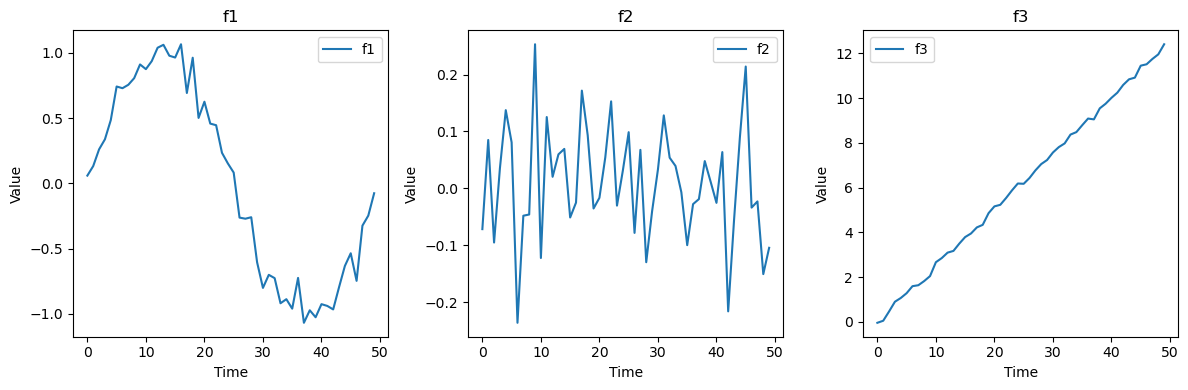

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(f1(), label='f1')
ax[0].set_title('f1')
ax[1].plot(f2(), label='f2')
ax[1].set_title('f2')
ax[2].plot(f3(), label='f3')
ax[2].set_title('f3')
for a in ax:
    a.legend()
    a.set_xlabel('Time')
    a.set_ylabel('Value')
plt.tight_layout()
plt.show()

In [26]:
# generate batch of data

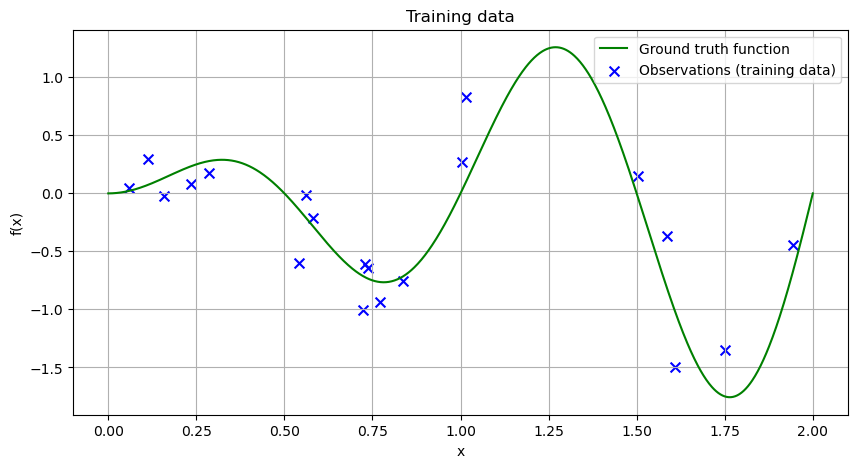

In [657]:
N = 1000

# X's
Xs = torch.linspace(0, 2, N).view(-1, 1)

# function f
def f(x):
    return x * torch.sin(x * (2 * math.pi))

# ground truth function values
fs = f(Xs)

# noise of observations y vs true function f(x)
NOISE = 1e-1 # sigma^2
ys = fs + torch.randn(fs.size()) * math.sqrt(NOISE)

# training data (ie number of observations)
N_SAMPLES = 20
idx = torch.randperm(N)[:N_SAMPLES]  # random indices for training data
Xs_train = Xs[idx]
ys_train = ys[idx]

# plot data
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(Xs.numpy(), fs.numpy(), 'green', label='Ground truth function')
ax.scatter(Xs_train.numpy(), ys_train.numpy(), marker='x', c='b', label='Observations (training data)', s=50)
ax.set_title('Training data')
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.legend()
ax.grid()
plt.show()

# GP on Scikit

In [658]:
kernel = 1.0 * RBF(length_scale=5, length_scale_bounds=(1e-3, 1.0e+3)) + WhiteKernel(
    noise_level=5*1e-4, noise_level_bounds=(1e-6, 10.0)
)

In [659]:
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.0, normalize_y=True, n_restarts_optimizer=10)

t1 = timeit.default_timer()
print("Training Gaussian Process Regressor...")
gpr.fit(Xs_train, ys_train)
t2 = timeit.default_timer()
print("Training time: {:.2f} seconds".format(t2 - t1))

Training Gaussian Process Regressor...
Training time: 0.14 seconds


In [660]:
y_mean, y_std = gpr.predict(Xs, return_std=True)

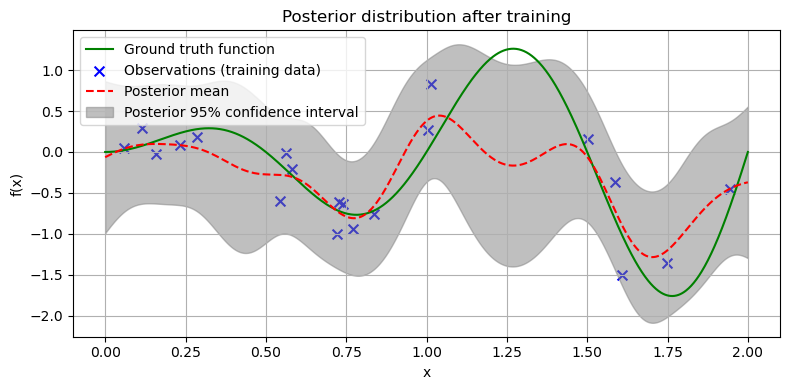

In [661]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.plot(Xs.cpu().numpy(), fs.cpu().numpy(), c='green', label='Ground truth function')
ax.scatter(Xs_train.cpu().numpy(), ys_train.cpu().numpy(), c='b', marker='x', label='Observations (training data)', s=50)
ax.plot(Xs.cpu().numpy(), y_mean, 'r', linestyle='--', label='Posterior mean')
ax.fill_between(Xs.cpu().numpy().flatten(),
                            y_mean - 2 * y_std,
                            y_mean + 2 * y_std,
                            color='gray', alpha=0.5, label='Posterior 95% confidence interval')
ax.set_title(f'Posterior distribution after training')
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

In [662]:
# print(f"Posterior mean : {y_mean}")

In [663]:
# print(f"Posterior Std dev : {y_std}")

In [664]:
# output model parameters
print("Model parameters:")
print(gpr.kernel_)
print(f"Negative Log Likelihood (lower is better): {-gpr.log_marginal_likelihood():.2f}")

Model parameters:
0.92**2 * RBF(length_scale=0.115) + WhiteKernel(noise_level=0.285)
Negative Log Likelihood (lower is better): 24.75


# GP on GPyTorch

In [665]:
# We will use the simplest form of GP model, exact inference

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        
        """An __init__ method that takes the training data and a likelihood, 
        and constructs whatever objects are necessary for the model"s forward method. 
        This will most commonly include things like a mean module and a kernel module.
        """
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        # constant mean as prior mean
        self.mean_module = gpytorch.means.ConstantMean()
        # RBF kernel as prior covariance
        # first, specify a RBF kernel with a SmoothedBoxPrior on the lengthscale (approx Uniform)
        self.rbf = gpytorch.kernels.RBFKernel(lengthscale_prior=gpytorch.priors.SmoothedBoxPrior(1e-3, 1e+3, sigma=1e-2))
        # then, scale the RBF kernel with a SmoothedBoxPrior on the outputscale (approx Uniform)
        self.covar_module = gpytorch.kernels.ScaleKernel(self.rbf, outputscale_prior=gpytorch.priors.SmoothedBoxPrior(1e-3, 1e+3, sigma=1e-2))

    def forward(self, x):
        """A forward method that takes in some n x d data x and returns a MultivariateNormal with the prior mean and covariance evaluated at x. 
        In other words, we return the vector mu(x) and the n x n matrix representing the prior mean and covariance matrix of the GP.
        """
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

## Going to GPU

In [666]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(f"Using {device}")

torch.set_default_dtype(torch.float64)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cuda
GPU Name: NVIDIA GeForce RTX 4090
Total GPU Memory: 23.6 GB


In [667]:
# Go to GPU when available

if torch.cuda.is_available():
    print(f"Going to GPU")
    Xs_train = Xs_train.squeeze().cuda()  # remove the extra dimension to get tensor sizes (N)
    ys_train = ys_train.squeeze().cuda()
    Xs = Xs.squeeze().cuda()  # remove the extra dimension to get tensor sizes (N)

Going to GPU


In [668]:
print(f"Xs: {Xs.size()}, Xs_train: {Xs_train.size()}, ys_train: {ys_train.size()}")

Xs: torch.Size([1000]), Xs_train: torch.Size([20]), ys_train: torch.Size([20])


## Training

### Which likelihood (mapping between f(x) and observations y ) ? 
### y = f(x) + .. ?

In [669]:
# Choose the likelihood
# https://docs.gpytorch.ai/en/stable/likelihoods.html

# when given a MultivariateNormal distribution f(x) as input,
# the likelihood will return the marginal distribution p(y | f(x))

# LIKELIHOODS

# 0 -------------------------------------------------------------------------------------------------
# Here, the GaussianLikelihood posits a constant noise level across all observations.
# The allowed noise can be constrained to be within a specified interval.
# this allows an exact noise-free GP
noise_interval = gpytorch.constraints.Interval(1e-6, 1e+1)  # interval for noise
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=noise_interval) #, learn_additional_noise=True)

# 1-------------------------------------------------------------------------------------------------
# If we do not specify anything, the model will learn noise on the observations.
# ==> THE MODEL WILL ADD NOISE TO THE POSTERIOR f(X)
# likelihood = gpytorch.likelihoods.GaussianLikelihood()

# 2 -------------------------------------------------------------------------------------------------
# we test also a FixedNoiseGaussianLikelihood, which assumes that the noise can be different for each observation
# here, we set a very small fixed noise, and enforce no learning of the additional noise parameter
# => EQUIVALENT TO AN EXACT GP WITH NO NOISE
# noises = torch.ones_like(Xs_train) * 1e-6  # fixed noise for each observation
# likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=noises, learn_additional_noise=False)

# 3 -------------------------------------------------------------------------------------------------
# we test also a FixedNoiseGaussianLikelihood, which assumes that the noise can be different for each observation
# here, we set a very small fixed noise, and allow learning of the additional noise parameter
# # ==> EQUIVALENT TO #1
# noises = torch.ones_like(Xs_train) * 1e-6  # fixed noise for each observation
# likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=noises, learn_additional_noise=True)

In [670]:
# initialize the model and the likelihood
# the model is instantiated with the N observations, 
# the GP prior (mean and covariance), 
# and the likelihood
model = ExactGPModel(Xs_train, ys_train, likelihood)

In [671]:
model = model.cuda()
likelihood = likelihood.cuda()

In [672]:
output = model(Xs_train)

print(f"output type: {type(output)}")
print(f"output mean: {output.mean.size()}")
print(f"output covariance: {output.covariance_matrix.size()}")

output type: <class 'gpytorch.distributions.multivariate_normal.MultivariateNormal'>
output mean: torch.Size([20])
output covariance: torch.Size([20, 20])


In [673]:
model.train()  # set the model to training mode
likelihood.train()  # set the likelihood to training mode

# Use the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [674]:
# loops between display of results
iterations_between_displays = 10

# threshold for change in loss between two iterations
threshold = 1e-8
max_iters = 20000  # maximum number of iterations

# Training loop
decrease = torch.tensor([float('inf')], device=device)  # initialize decrease to infinity
i = 0
    
while decrease >= threshold and i < max_iters:
    
    # training mode
    model.train()
    likelihood.train()
    
    # reset gradients to zero as usual
    optimizer.zero_grad()
    
    # output from model
    # this returns a MultivariateNormal distribution N( m(x_train), K(x_train, x_train) ) on the training data
    output = model(Xs_train)
    
    # compute loss
    # mll is the marginal log likelihood
    # of the data ys_train given the MV Normal distribution 
    # returned by the model on the training data Xs_train
    loss = -mll(output, ys_train)
    
    # gradient descent step
    loss.backward()
    optimizer.step()
    
    # compute decrease in loss
    if i >= 1:
        decrease = torch.abs(torch.tensor(prev_loss - loss.item()))
        prev_loss = loss.item()
    else:
        prev_loss = loss.item()
    
    # display posterior distribution
    if i % iterations_between_displays == 0:
        
        # print the loss
        # print(f"Iter {i + 1:<5} - Loss: {loss.item():.4e} - lengthscale : {model.covar_module.base_kernel.lengthscale.item():.4f} - noise : {model.likelihood.noise.item():.4f} - decrease: {decrease.item():.4e}")
        print(f"Iteration {i+1:<6}, Loss: {loss.item():.3e}, \
            Error decrease: {decrease.item()*100:.2e}%, \
                lengthscale : {model.covar_module.base_kernel.lengthscale.item():.2e}") #, noise (variance): {model.likelihood.noise.item():.2e}")
        
        # model.eval()  # set the model to evaluation mode
        # likelihood.eval()
        
        # with torch.no_grad():
        #     # get posterior distribution on a set of test points
        #     posterior = model(Xs)
            
        #     # get posterior mean and covariance
        #     posterior_mean = posterior.mean
        #     posterior_covariance = posterior.covariance_matrix
            
        #     # plot the posterior distribution
        #     fig, ax = plt.subplots(1, 1, figsize=(8, 4))
        #     ax.plot(Xs.cpu().numpy(), fs.cpu().numpy(), c='green', label='Ground truth function')
        #     ax.scatter(Xs_train.cpu().numpy(), ys_train.cpu().numpy(), c='b', marker='x', label='Observations (training data)', s=50)
        #     ax.plot(Xs.cpu().numpy(), posterior_mean.cpu().numpy(), 'r', linestyle='--', label='Posterior mean')
        #     ax.fill_between(Xs.cpu().numpy().flatten(),
        #                     (posterior_mean - 2 * torch.sqrt(posterior_covariance.diagonal())).cpu().numpy(),
        #                     (posterior_mean + 2 * torch.sqrt(posterior_covariance.diagonal())).cpu().numpy(),
        #                     color='gray', alpha=0.5, label='Posterior 95% confidence interval')
        #     ax.set_title(f'Posterior distribution after {i+1} iterations')
        #     ax.set_xlabel('x')
        #     ax.set_ylabel('f(x)')
        #     ax.legend()
        #     ax.grid()
        #     plt.tight_layout()
        #     plt.show()
            
    i += 1
    
print(f"Final loss : {loss.item():.4e}")

Iteration 1     , Loss: 2.840e+00,             Error decrease: inf%,                 lengthscale : 7.44e-01
Iteration 11    , Loss: 2.543e+00,             Error decrease: 3.35e+00%,                 lengthscale : 1.34e+00


Iteration 21    , Loss: 2.199e+00,             Error decrease: 3.31e+00%,                 lengthscale : 1.84e+00
Iteration 31    , Loss: 1.959e+00,             Error decrease: 1.31e+00%,                 lengthscale : 1.88e+00
Iteration 41    , Loss: 1.945e+00,             Error decrease: 2.11e-01%,                 lengthscale : 1.23e+00
Iteration 51    , Loss: 1.926e+00,             Error decrease: 2.78e-01%,                 lengthscale : 5.64e-01
Iteration 61    , Loss: 1.908e+00,             Error decrease: 1.10e-01%,                 lengthscale : 1.94e-01
Iteration 71    , Loss: 1.900e+00,             Error decrease: 9.22e-02%,                 lengthscale : 7.46e-02
Iteration 81    , Loss: 1.876e+00,             Error decrease: 4.56e-01%,                 lengthscale : 1.04e-01
Iteration 91    , Loss: 1.804e+00,             Error decrease: 8.13e-01%,                 lengthscale : 1.06e-01
Iteration 101   , Loss: 1.750e+00,             Error decrease: 4.04e-01%,                 length

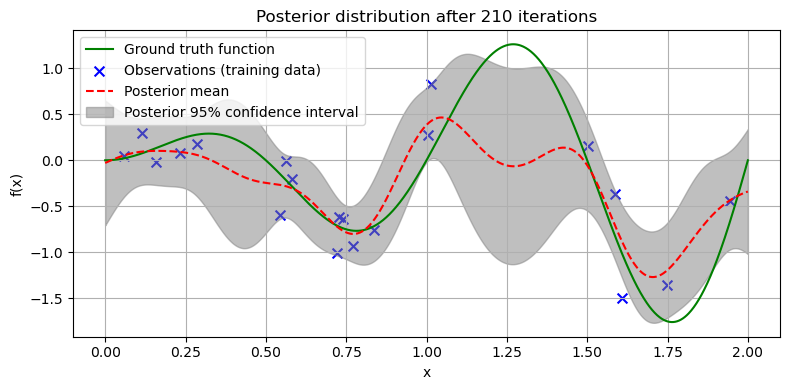

In [675]:
model.eval()  # set the model to evaluation mode
likelihood.eval()  # set the likelihood to evaluation mode

with torch.no_grad():
            # get posterior distribution on a set of test points
            posterior = model(Xs)
            
            # get posterior mean and covariance
            posterior_mean = posterior.mean
            posterior_covariance = posterior.covariance_matrix
            
            # plot the posterior distribution
            fig, ax = plt.subplots(1, 1, figsize=(8, 4))
            ax.plot(Xs.cpu().numpy(), fs.cpu().numpy(), c='green', label='Ground truth function')
            ax.scatter(Xs_train.cpu().numpy(), ys_train.cpu().numpy(), c='b', marker='x', label='Observations (training data)', s=50)
            ax.plot(Xs.cpu().numpy(), posterior_mean.cpu().numpy(), 'r', linestyle='--', label='Posterior mean')
            ax.fill_between(Xs.cpu().numpy().flatten(),
                            (posterior_mean - 2 * torch.sqrt(posterior_covariance.diagonal())).cpu().numpy(),
                            (posterior_mean + 2 * torch.sqrt(posterior_covariance.diagonal())).cpu().numpy(),
                            color='gray', alpha=0.5, label='Posterior 95% confidence interval')
            ax.set_title(f'Posterior distribution after {i+1} iterations')
            ax.set_xlabel('x')
            ax.set_ylabel('f(x)')
            ax.legend()
            ax.grid()
            plt.tight_layout()
            plt.show()

In [676]:
# FROM THE DOCS : Just as a user defined GP model returns a MultivariateNormal containing the prior mean and covariance from forward, 
# a trained GP model in eval mode returns a MultivariateNormal containing the posterior mean and covariance.

# model.train()  # set the model to evaluation mode
# likelihood.train()  # set the likelihood to evaluation mode

# print("Model parameters after training (mode TRAIN):")
# print(f"Lengthscale : {model.covar_module.base_kernel.lengthscale.item():.2e}")
# print(f"Log Marginal Likelihood en mode train : {mll(model(Xs_train), ys_train):.2e}")
# print(f"Loss : {loss.item():.2e}")

model.eval()
likelihood.eval()

print("Model parameters after training (mode EVAL):")
print(f"Lengthscale : {model.covar_module.base_kernel.lengthscale.item():.3f}")
print(f"Last Loss : {loss.item():.3f}")
print(f"Negative Log Marginal Likelihood (lower is better): {-mll(model(Xs_train), ys_train):.2f}")

Model parameters after training (mode EVAL):
Lengthscale : 0.119
Last Loss : 1.731
Negative Log Marginal Likelihood (lower is better): 1.20


/home/benjamin.deporte/.conda/envs/torchy/lib/python3.12/site-packages/gpytorch/models/exact_gp.py:283: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [677]:
# model.eval()
# likelihood.eval()

# output_eval = model(Xs)

In [678]:
# output_eval.mean

In [679]:
# output_eval.covariance_matrix.diagonal()